In [33]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

In [55]:
def get_data(filename, ndata, r):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29 - basically r selects the course-grainedness, r=1 means no course-graining
    r = r
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = scipy.io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x, y

r = 1
s = int(((421 - 1) / r) + 1)

x_train, y_train = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth1.mat", 1000, r)
x_test, y_test = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth2.mat", 1000, r)

Visualise training data. Mapping from permeability field `x` $ = K(x, y)$ to a pressure field `y` $ = h(x,y)$, both defined on the domain $[0,1]^2$

2 (1000, 177241) (177241, 2) (1000, 177241)
2 (1000, 177241) (177241, 2) (1000, 177241)


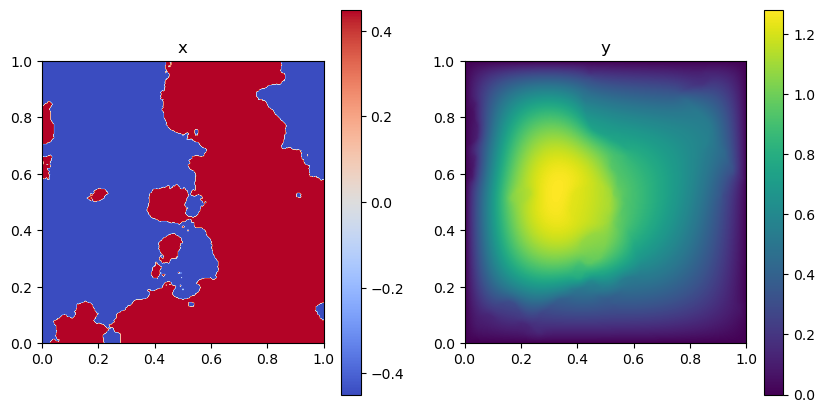

In [56]:
index_to_plot = 12

print(len(x_train), x_train[0].shape, x_train[1].shape, y_train.shape)
print(len(x_test), x_test[0].shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[0][index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

# training

reshape input and output data into a 1d vector - naive but who knows how well it will work (data was given in 1d form from the `get_data()` function)

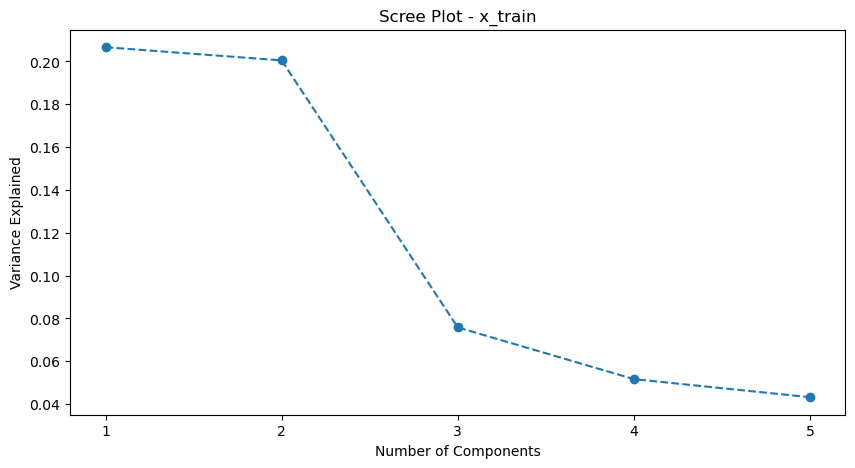

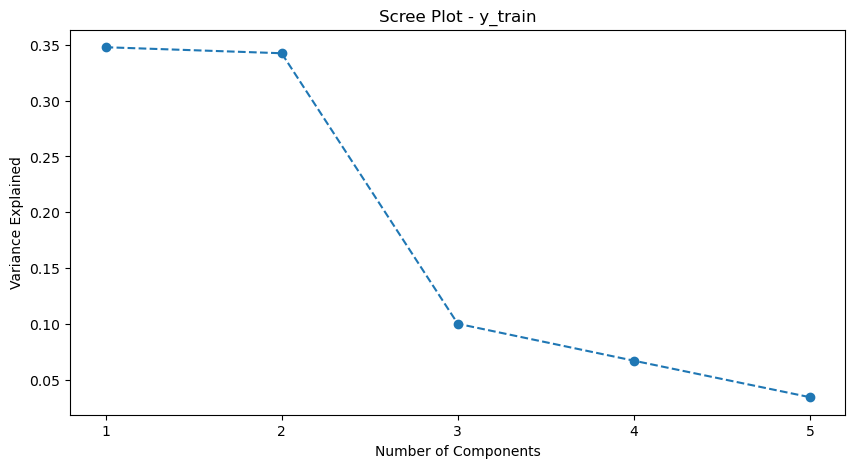

In [57]:
x_pca = PCA(n_components=5)
y_pca = PCA(n_components=5)
x_lowdim = x_pca.fit_transform(x_train[0])
y_lowdim = y_pca.fit_transform(y_train)

x_explained_variance = x_pca.explained_variance_ratio_
y_explained_variance = y_pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(x_explained_variance) + 1), x_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - x_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(x_explained_variance) + 1))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_explained_variance) + 1), y_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - y_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(y_explained_variance) + 1))
plt.show()

train model and debug by visualising `y_train` PCA components as a function of the two `x_train` PCA components - the PCA 4 and 5 for `y_train` seem to be too high? visuals are showing ~100s, but the histograms below show ~40. when plotting where observations were taken, i think this is an artifact of using cubic interpolation

(1000, 2)
(1000, 5)
linear
(1000, 5)
(1000, 5)
[LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]


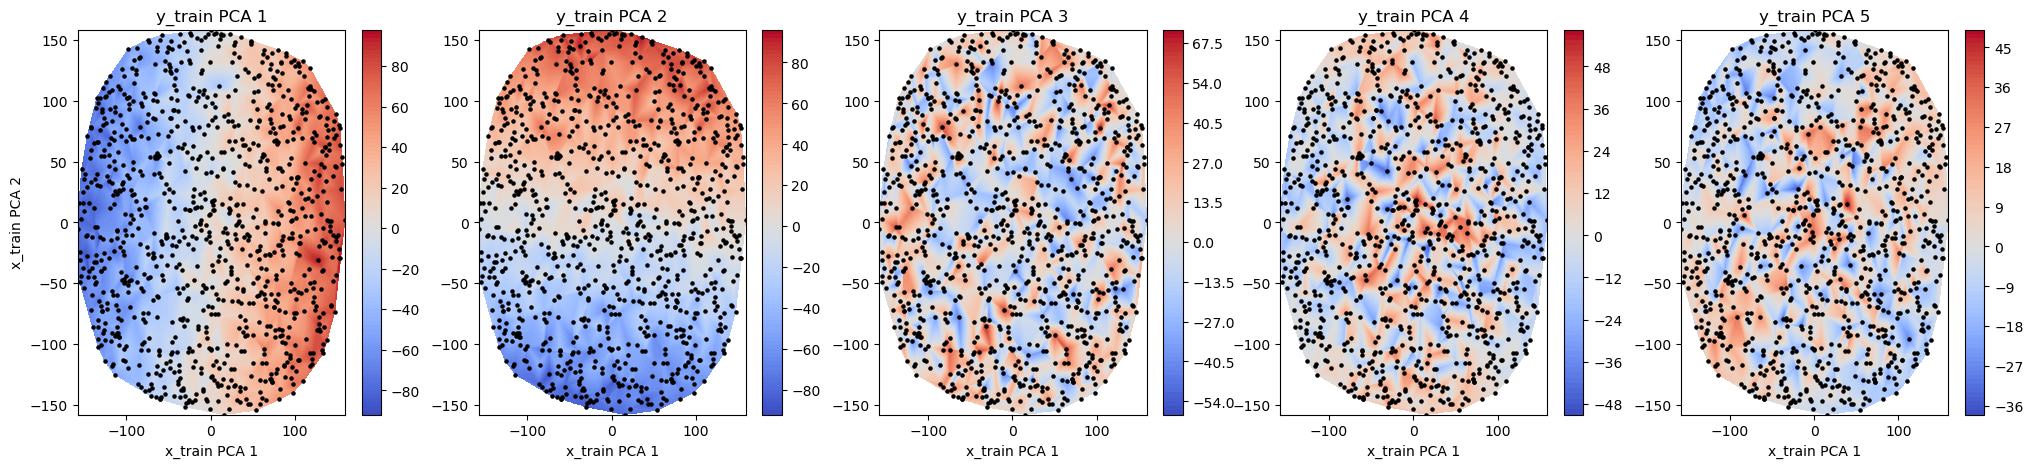

In [62]:
debug = True

low_dim_x = 2
low_dim_y = 5
GP_params = {'kernel': gpx.kernels.Matern12(), 'mean_function': gpx.mean_functions.Zero()}

reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor='linear', GP_params=GP_params)
reg.fit(x_train[0], y_train, save=True)

print(reg.low_dim_regressor_list)

if debug and low_dim_x == 2:
    fig, ax = plt.subplots(1, low_dim_y, figsize=(5*low_dim_y, 5))
    for i in range(low_dim_y):
        x_PCA_1 = reg.X_train_low_dim[:, 0]
        x_PCA_2 = reg.X_train_low_dim[:, 1]
        y_PCA_i = reg.Y_train_low_dim[:, i]
        
        grid_x_PCA_1, grid_x_PCA_2 = np.meshgrid(np.linspace(x_PCA_1.min(), x_PCA_1.max(), 1000), np.linspace(x_PCA_2.min(), x_PCA_2.max(), 1000))
        grid_y_PCA_i = griddata((x_PCA_1, x_PCA_2), y_PCA_i, (grid_x_PCA_1, grid_x_PCA_2), method='linear')

        cf = ax[i].contourf(grid_x_PCA_1, grid_x_PCA_2, grid_y_PCA_i, levels=100, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
        ax[i].scatter(x_PCA_1, x_PCA_2, c='k', s=5)
        fig.colorbar(cf, ax=ax[i])
        
        ax[i].set_title(f"y_train PCA {i+1}")
        ax[i].set_xlabel("x_train PCA 1")
    ax[0].set_ylabel("x_train PCA 2")


see how well the low-dim regressor is doing

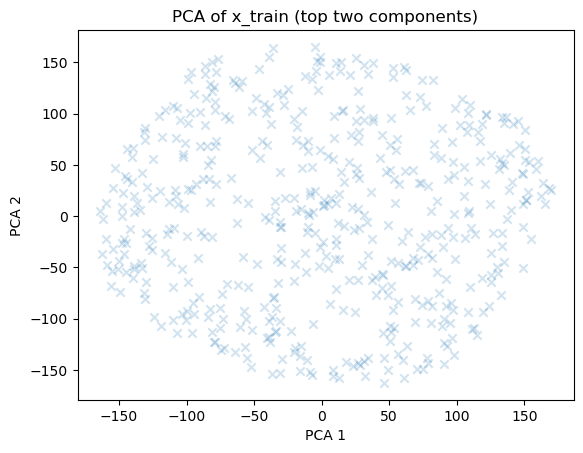

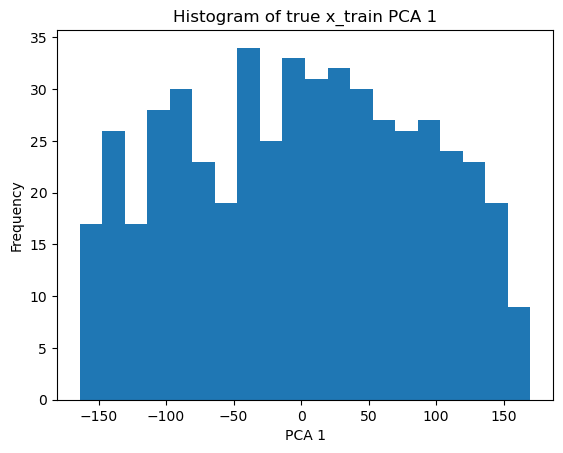

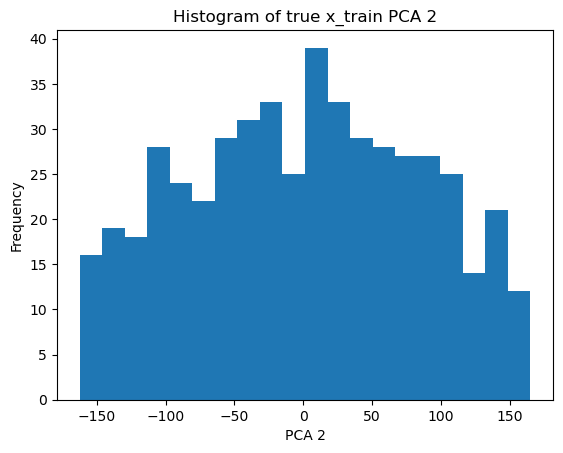

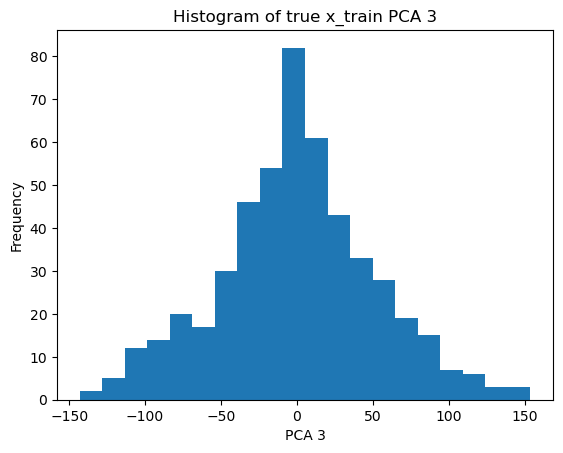

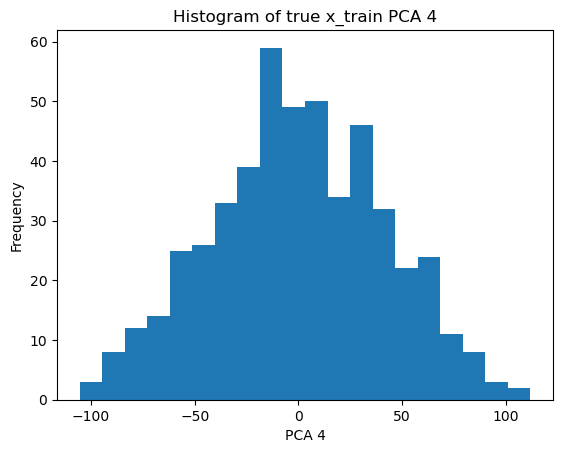

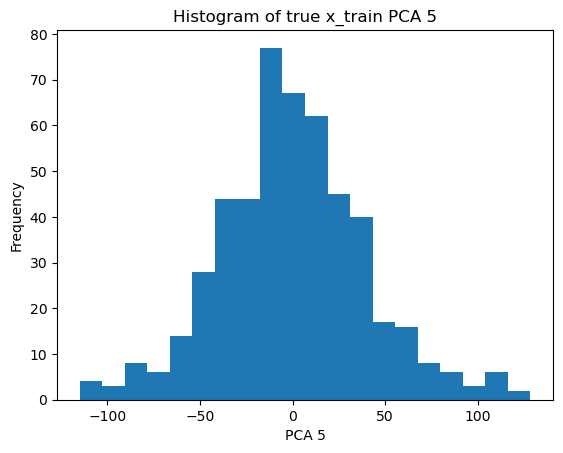

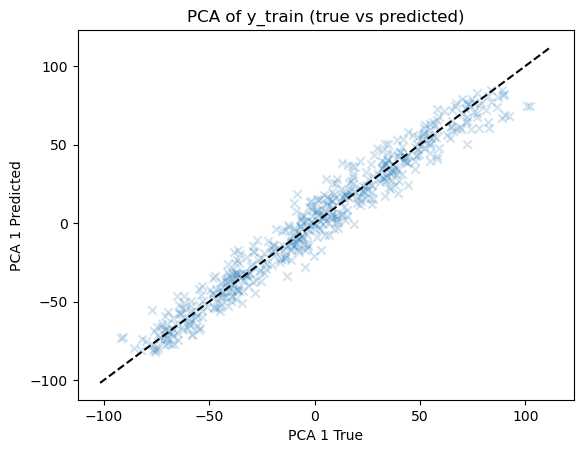

MSE: 81.15529560447816
Correlation: 0.9793362264635322


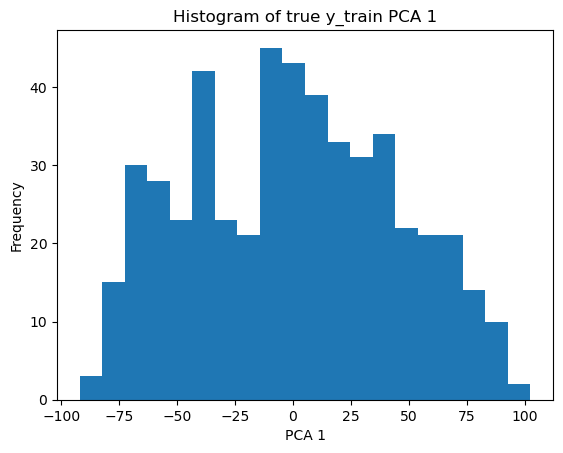

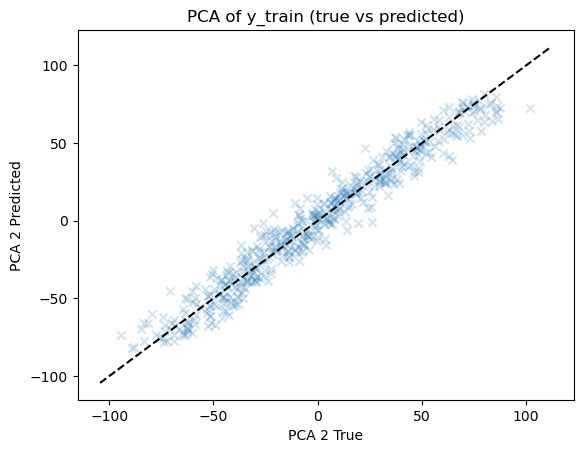

MSE: 87.35185852995886
Correlation: 0.9753676630362096


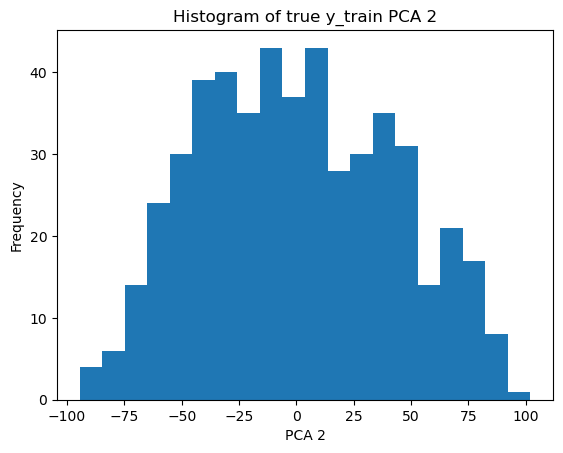

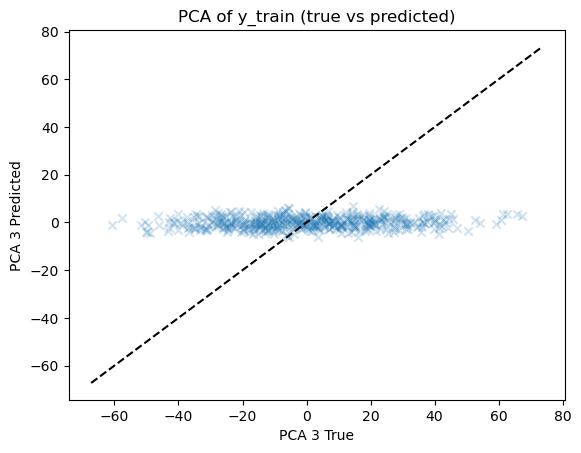

MSE: 540.4159765323489
Correlation: 0.09973656964030149


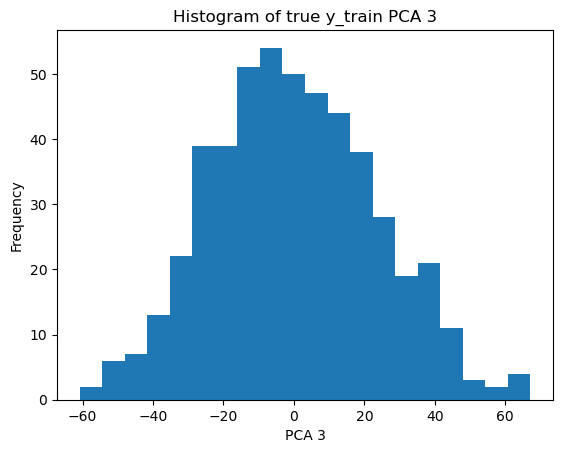

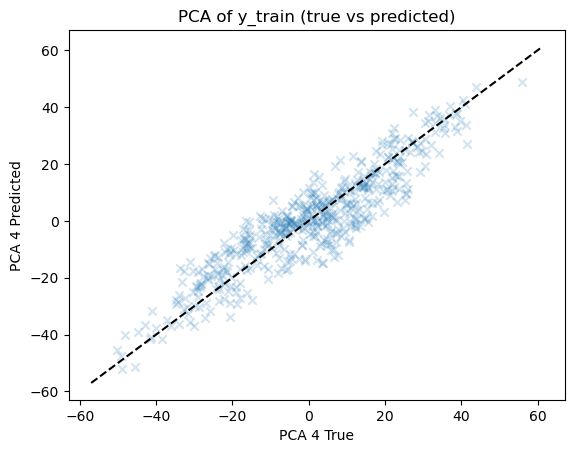

MSE: 59.58589990924009
Correlation: 0.9153542445108747


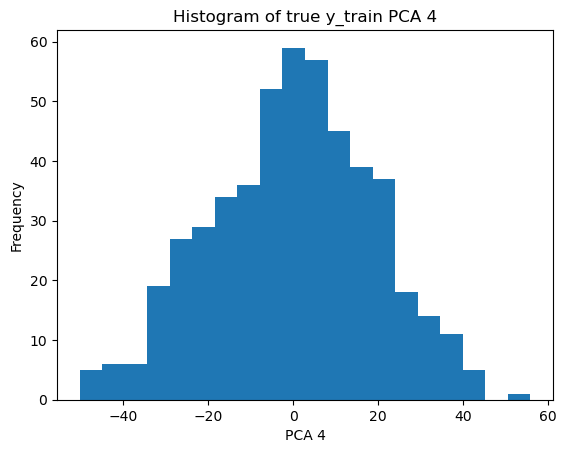

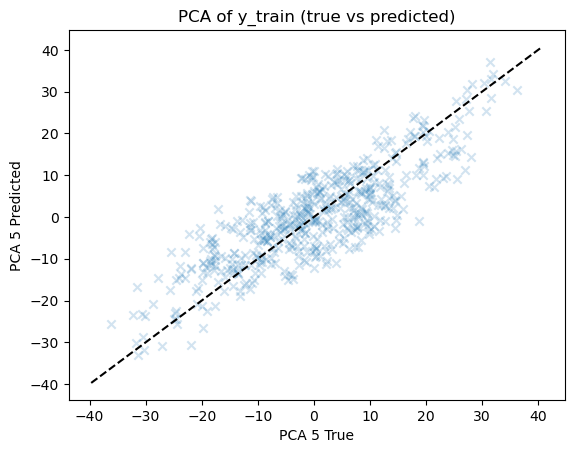

MSE: 53.49309626367437
Correlation: 0.8426904481355539


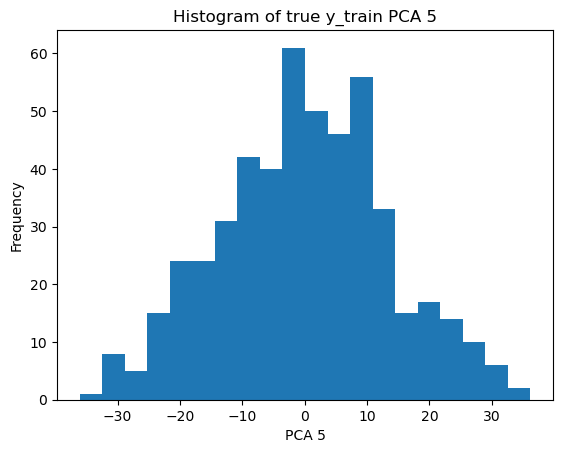

In [47]:

if low_dim_x > 1:
    plt.figure()
    plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of x_train (top two components)')
    plt.show()
if low_dim_x == 1:
    for i in range(low_dim_y):
        plt.figure()
        plt.scatter(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        plt.plot(reg.X_train_low_dim[:, 0], reg.low_dim_regressor_list[i].predict(reg.X_train_low_dim), color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        plt.xlabel('x_train PCA 1')
        plt.ylabel(f'y_train PCA {i+1}')
        plt.show()

for i in range(low_dim_x):
    plt.figure()
    plt.hist(reg.X_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true x_train PCA {i+1}')
    plt.show()


for i in range(low_dim_y):
    plt.figure()
    ax = plt.gca()
    plt.scatter(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], marker='x', alpha=0.2)
    plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    plt.xlabel(f'PCA {i+1} True')
    plt.ylabel(f'PCA {i+1} Predicted')
    plt.title('PCA of y_train (true vs predicted)')
    plt.show()

    mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'MSE: {mse}')
    r = np.corrcoef(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'Correlation: {r[0, 1]}')

    plt.figure()
    plt.hist(reg.Y_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true y_train PCA {i+1}')
    plt.show()

# testing

In [48]:
y_test_pred = reg.predict(x_test[0])
rmse, r2 = reg.test(x_test[0], y_test)
L2_relative_error = np.sqrt(np.sum((y_test - y_test_pred) ** 2, axis = 1))/np.sqrt(np.sum(y_test ** 2, axis = 1))

print(f' average L2 error: {L2_relative_error.mean()}')

 average L2 error: 0.12866410810725937


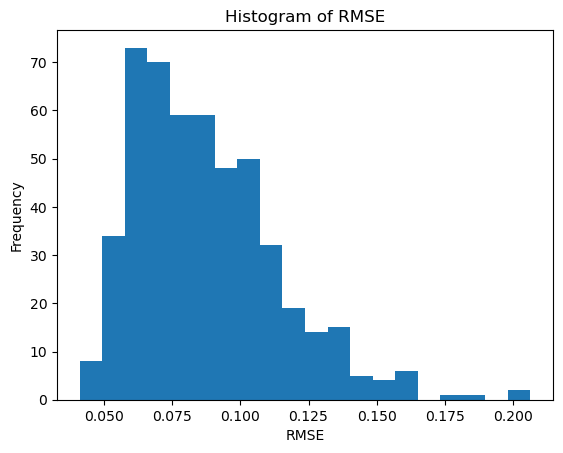

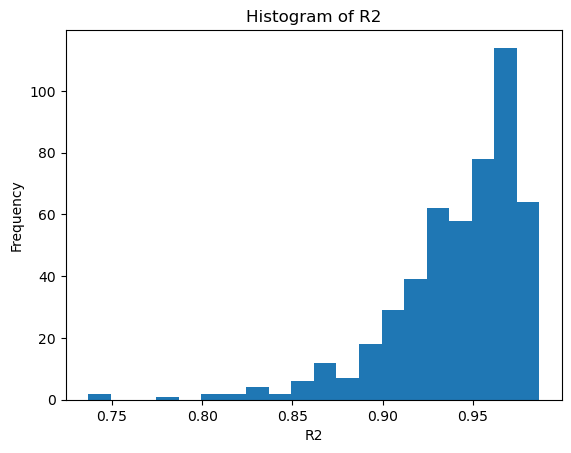

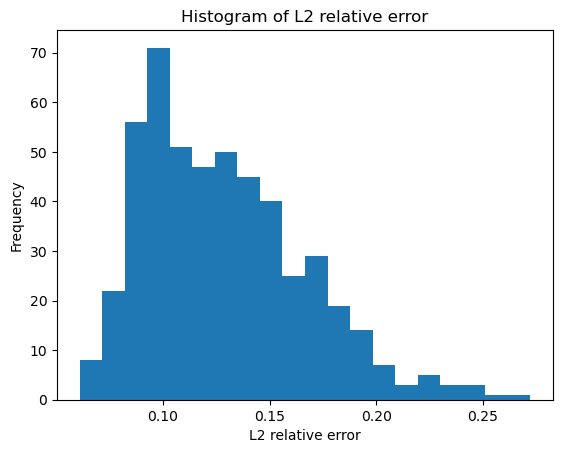

In [49]:
plt.figure()
plt.hist(rmse, bins=20)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE')
plt.show()

plt.figure()
plt.hist(r2, bins=20)
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.title('Histogram of R2')
plt.show()

plt.figure()
plt.hist(L2_relative_error, bins=20)
plt.xlabel('L2 relative error')
plt.ylabel('Frequency')
plt.title('Histogram of L2 relative error')
plt.show()

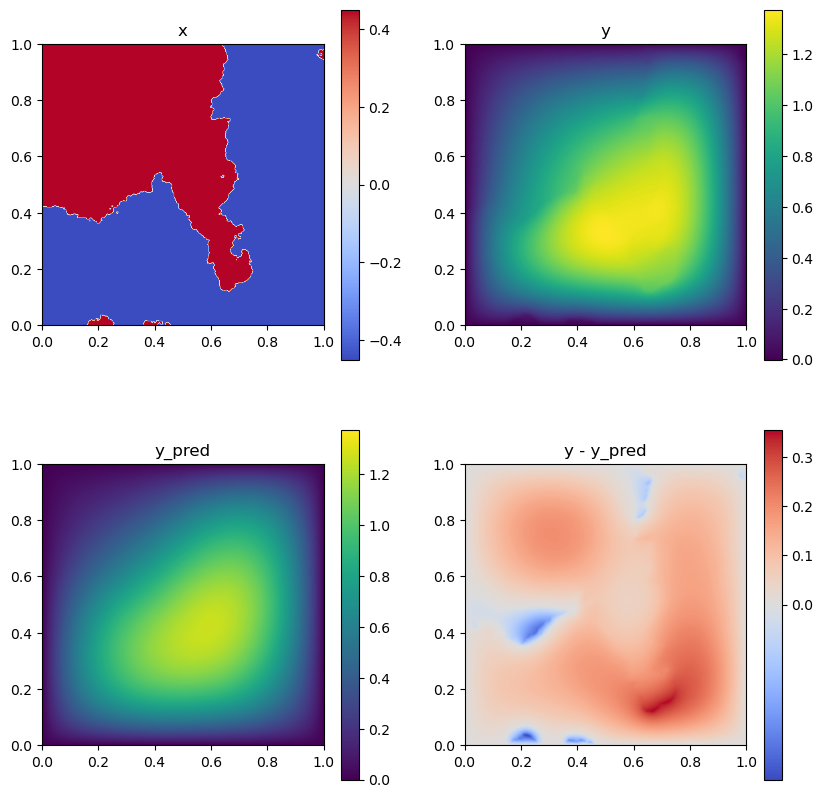

In [51]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_test_pred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_test_pred[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
im0 = ax[0,0].imshow(x_test[0][index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
ax[0,0].set_title("x")
im1 = ax[0,1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0,1].set_title("y")
im2 = ax[1,0].imshow(y_test_pred[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1,0].set_title("y_pred")
im3 = ax[1,1].imshow(y_test[index_to_plot, :].reshape(s, s) - y_test_pred[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
ax[1,1].set_title("y - y_pred")
fig.colorbar(im0, ax=ax[0,0])
fig.colorbar(im1, ax=ax[0,1])
fig.colorbar(im2, ax=ax[1,0])
fig.colorbar(im3, ax=ax[1,1])
plt.show()